# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Install and Load Libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 46.0 MB/s 
     |████████████████████████████████| 147 kB 41.0 MB/s 
     |████████████████████████████████| 63 kB 552 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=eae2c3ab959fb389dad4ed3fea9a9dd81f1c70e41c7cdf48bbcb63a1fb7343bb
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
# Imports
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import os

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# imblearn

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1.0 Training



## 1.0.2 Holdout Configuration

In [4]:
# global variables

# ratio used to split train and validation data
val_size = 0.30
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [5]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)


wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


19-07-2022 22:35:25 Downloading and reading train artifact


In [6]:
# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")

# split-out train/validation dataset
train, val = train_test_split(  df_train,
                                test_size=val_size,
                                random_state=seed,
                                shuffle=True
                                )

19-07-2022 22:35:25 Spliting data into train/val


In [7]:
logger.info("train: {}".format(train.shape))
logger.info("val: {}".format(val.shape))

19-07-2022 22:35:27 train: (22152, 17)
19-07-2022 22:35:27 val: (9495, 17)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [8]:
logger.info("Outlier Removal")
# temporary variable
x = train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

19-07-2022 22:35:27 Outlier Removal


In [9]:
logger.info("train shape [original]: {}".format(train.shape))
logger.info("train shape [outlier removal]: {}".format(train.loc[mask,:].shape))

19-07-2022 22:35:28 train shape [original]: (22152, 17)
19-07-2022 22:35:28 train shape [outlier removal]: (21634, 17)


In [10]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
train = train.loc[mask,:].copy()

### 1.1.2 Balancing Data

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [11]:
train.y.value_counts()

no     19250
yes     2384
Name: y, dtype: int64

In [12]:
# Return dataframe balanced: oversample and undersample
def resaple_bal(df, seed): 
  
  x_train = df.loc[:, df.columns != 'y']
  y_train = df.loc[:, df.columns == 'y']  
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.7, random_state=seed) # 0.4
  undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
  x_train, y_train = oversample.fit_resample(x_train, y_train)
  # x_train, y_train = undersample.fit_resample(x_train, y_train)
  df_o = pd.concat([x_train, y_train], axis=1)
  df_o = df_o.sample(frac=1, random_state=seed).reset_index(drop=True)
  return df_o


In [13]:
logger.info("Balance data")
train = resaple_bal( train, seed)

19-07-2022 22:35:45 Balance data


In [14]:
# for validation purposes
# train.loc[0:10, 'y']

In [15]:
# for validation purposes
train.y.value_counts()

no     19250
yes    13475
Name: y, dtype: int64

### 1.1.3 Encoding Target Variable

In [16]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
train.loc[:, 'y'] = le.fit_transform(train.loc[:, 'y'])

# transform y_test (avoiding data leakage)
val.loc[:, 'y'] = le.transform(val.loc[:, 'y'])

val = val.reset_index(drop=True)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

19-07-2022 22:35:52 Encoding Target Variable
19-07-2022 22:35:52 Classes [0, 1]: ['no' 'yes']


### 1.1.4 Data split-out features and label

In [17]:
x_train = train.loc[:, train.columns != 'y']
y_train = train.loc[:, train.columns == 'y']  
x_val = val.loc[:, val.columns != 'y']
y_val = val.loc[:, val.columns == 'y']  

## 1.2 Data full-pipeline

### 1.2.1 Classes and Functions for Handling Features

These custom classes and functions will handle processing the features in the pipeline

In [18]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      exceptions = ['default', 'loan']
      self.feature_names = copy_exception(feature_names, exceptions) 
      #self.feature_names = feature_names
    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']

            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # minimize the cardinality month
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns
        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # Map padys=-1 into a large value (1000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 1000
        # update columns name
        self.colnames = df.columns.tolist()
        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values
        return df

### 1.2.2 Validation of Classes and functions to handle features

In [19]:
# for validation purposes
f_sel = copy_exception(x_train.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [20]:
# for validation purposes
x_train.month.unique()

array(['oct', 'sep', 'jun', 'may', 'aug', 'feb', 'apr', 'jul', 'mar',
       'nov', 'jan', 'dec'], dtype=object)

,job,marital,education,housing,contact,month,poutcome
0,white-collar,single,tertiary,no,telephone,4st,unknown
1,white-collar,single,tertiary,yes,cellular,3st,unknown
2,blue-collar,married,secondary,yes,unknown,2st,unknown
3,white-collar,married,tertiary,no,telephone,2st,unknown
4,white-collar,single,tertiary,yes,unknown,2st,unknown


In [22]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [23]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.2.2.1 Handling Numerical Features

In [28]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,34,7478,30,345,1,-1,0
1,32,1954,10,107,1,-1,0
2,28,2788,6,369,2,-1,0
3,57,350,4,87,3,-1,0
4,32,1493,28,65,11,-1,0


In [29]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-0.64127698,  2.12070467,  1.85187016, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-0.82838864,  0.17228003, -0.68885211, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-1.20261197,  0.46644842, -1.19699657, ..., -0.16458177,
         9.64542488, -0.3552689 ],
       ...,
       [ 0.2007255 ,  0.12113565, -1.19699657, ..., -0.54019641,
         9.64542488, -0.3552689 ],
       [-0.36060949, -0.55608653, -0.30774377, ...,  0.58664752,
         9.64542488, -0.3552689 ],
       [ 0.85561632, -0.50776391,  1.08965348, ...,  0.58664752,
         9.64542488, -0.3552689 ]])

In [30]:
# for validation purposes
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.2.2.2 Handling Categorical Features

In [25]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,management,single,tertiary,no,telephone,oct,unknown
1,management,single,tertiary,yes,cellular,sep,unknown
2,blue-collar,married,secondary,yes,unknown,jun,unknown
3,management,married,tertiary,no,telephone,may,unknown
4,management,single,tertiary,yes,unknown,may,unknown


In [26]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,white-collar,single,tertiary,no,telephone,4st,unknown
1,white-collar,single,tertiary,yes,cellular,3st,unknown
2,blue-collar,married,secondary,yes,unknown,2st,unknown
3,white-collar,married,tertiary,no,telephone,2st,unknown
4,white-collar,single,tertiary,yes,unknown,2st,unknown


### 1.2.3 Data Preparation Pipeline

In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipe = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
x_train_encoded = full_pipe.fit_transform(x_train)
x_val_encoded = full_pipe.transform(x_val)

# Transform the data
# cat_names is a numpy array
cat_names = full_pipe.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipe.get_params()["num_pipeline"][2].get_feature_names_out()
# Transform the data
x_train_encoded = pd.DataFrame(x_train_encoded,columns = cat_names + num_names)
x_val_encoded = pd.DataFrame(x_val_encoded ,columns = cat_names + num_names)

In [ ]:
train_encoded = pd.concat([x_train_encoded, y_train], axis=1)
val_encoded = pd.concat([x_val_encoded, y_val], axis=1)

In [ ]:
# for validation purposes
train_encoded #.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,34.0,7478.0,30.0,345.0,1.0,10000.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,32.0,1954.0,10.0,107.0,1.0,10000.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,28.0,2788.0,6.0,369.0,2.0,10000.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,57.0,350.0,4.0,87.0,3.0,10000.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,32.0,1493.0,28.0,65.0,11.0,10000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32720,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,51.0,-437.0,30.0,130.0,3.0,10000.0,0.0,0
32721,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,26.0,620.0,22.0,223.0,1.0,94.0,1.0,1
32722,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,43.0,1809.0,6.0,312.0,1.0,10000.0,0.0,1
32723,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,37.0,-111.0,13.0,147.0,4.0,10000.0,0.0,0


In [ ]:
val_encoded

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,27.0,1.0,2.0,261.0,8.0,10000.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,49.0,23.0,23.0,247.0,1.0,10000.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,33.0,1278.0,6.0,649.0,1.0,10000.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,59.0,266.0,30.0,147.0,2.0,10000.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,38.0,-3.0,20.0,251.0,2.0,101.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,31.0,1306.0,28.0,217.0,5.0,10000.0,0.0,0
9491,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,43.0,463.0,3.0,268.0,1.0,10000.0,0.0,0
9492,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,28.0,708.0,6.0,339.0,5.0,10000.0,0.0,0
9493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,27.0,220.0,19.0,480.0,1.0,10000.0,0.0,0


In [ ]:
# saving transformed train data to csv
train_encoded.to_csv("encoded_train_data.csv", index=False)
val_encoded.to_csv("encoded_val_data.csv", index=False)

run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="encode_data")

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▃▃▄▅▆▇▇▇▇▇▇▇▇▇█▇▇██████████▇██████████
loss,█▇▆▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_f1_score,▂▅▆▁▆▃▄▄▄▄▅▇▆█▇█▇▇▆██▇▃██▂▅▇▇▁▂▆▃▅█▆▅▇██
val_loss,▄▂▁▅▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▆▂▁▁██▁▃▂▁▂▂▁▁▁
Accuracy,0.87604
F1,0.57371
G-Mean,0.78781
Precision,0.49193
Recall,0.6881
best_epoch,27


In [ ]:
# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_train_data.csv",
                          type="encoded_data",
                          description="Upload encoded Train Data")

artifact.add_file("encoded_train_data.csv")
run.log_artifact(artifact)

# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_val_data.csv",
                          type="encoded_data",
                          description="Upload encoded Val Data")

artifact.add_file("encoded_val_data.csv")
run.log_artifact(artifact)

In [ ]:
run.finish()

os.remove('encoded_train_data.csv')
os.remove('encoded_val_data.csv')

## 1.6 Hyperparameter Tuning

## 4.1 Monitoring a neural network

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
import logging
from wandb.keras import WandbCallback
import pandas as pd
import numpy as np
import os

from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
from keras import callbacks
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from keras.constraints import max_norm
import matplotlib.pyplot as plt

In [ ]:
# os.environ['WANDB_NOTEBOOK_NAME'] = 'train_test.ipynb'

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

Better Genaralization

1. Regularization L2 ok
2. Penalize large weights 
3. weight constraint
4. Dropout ok
5. Noise ok (oversample)
6. Early stoping ok

In [ ]:
# Default values for hyperparameters
defaults = dict(layer_1 = 23,
                layer_2 = 39,
                learn_rate = 0.1,
                batch_size = 256,
                epoch = 500,
                dropout1 = 1.0,
                dropout2 = 0.5,
                l2_1 = 0.0,
                l2_2 = 0.0001,
                gradient_cliping = 1,
                bath_norm = 1
                )

# Default values for hyperparameters
# defaults = dict(layer_1 = 32,
#                 layer_2 = 32,
#                 learn_rate = 0.01,
#                 batch_size = 4096,
#                 epoch = 500,
#                 dropout1 = 1.0,
#                 dropout2 = 1.0,
#                 l2_1 = 0.0,
#                 l2_2 = 0.0,
#                 gradient_cliping = 0,
#                 bath_norm = 1
#                 )

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan", config= defaults, name="run_01")
config = wandb.config

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


In [ ]:
# Downloading and reading encoded train val artifact
logger.info("Downloading and reading encoded train artifact")
local_path = run.use_artifact("encoded_train_data.csv:latest").file()
train_encoded = pd.read_csv(local_path)

logger.info("Downloading and reading encoded val artifact")
local_path = run.use_artifact("encoded_val_data.csv:latest").file()
val_encoded = pd.read_csv(local_path)

x_train_encoded = train_encoded.loc[:, train_encoded.columns != 'y']
y_train = train_encoded.loc[:, train_encoded.columns == 'y']  
x_val_encoded = val_encoded.loc[:, val_encoded.columns != 'y']
y_val = val_encoded.loc[:, val_encoded.columns == 'y'] 

19-07-2022 19:25:29 Downloading and reading encoded train artifact
19-07-2022 19:25:30 Downloading and reading encoded val artifact


In [ ]:
train_encoded.y.value_counts()

0    19250
1    13475
Name: y, dtype: int64

In [ ]:
# Instantiate a classification model
model = tf.keras.Sequential()
if config.l2_1!=0.0:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1.0:
  model.add(layers.BatchNormalization())
if config.dropout1!=1.0:
  model.add(layers.Dropout(config.dropout1))
if config.l2_2!=0.0:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1:
  model.add(layers.BatchNormalization())
if config.dropout2!=1.0:
  model.add(layers.Dropout(config.dropout2))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
m_f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
m_bacc_score = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m_recall = tf.keras.metrics.Recall(thresholds=0.5)
m_precision = tf.keras.metrics.Precision(thresholds=0.5)
m_g_mean = tfa.metrics.GeometricMean()

# m_g_mean = tfa.metrics.GeometricMean()


# Instantiate an optimizer.
if config.gradient_cliping==0.0:
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
else:
    optimizer = tf.keras.optimizers.Adam( 
                                    learning_rate=config.learn_rate,
                                    clipvalue= config.gradient_cliping
                                    )


# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score,
                                                       m_bacc_score,
                                                       m_recall,
                                                       m_precision                                                                                                          
                                                       ]) 

In [ ]:
early_stopping = callbacks.EarlyStopping(
                monitor='val_f1_score',   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=100, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

In [ ]:
# %%wandb
# Add WandbCallback() to the fit function
hist = model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
          y= y_train,
          batch_size=config.batch_size,
          epochs=10, #config.epoch,
          validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val_bal)
          callbacks=[ WandbCallback(monitor="val_f1_score",
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=1)

# predict
y_pred = np.rint(model.predict(x_val_encoded)).ravel()

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
acc = accuracy_score(y_val.values.ravel(), y_pred)
#g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

logger.info("val_Accuracy: {}".format(acc))
logger.info("val_Precision: {}".format(precision))
logger.info("val_Recall: {}".format(recall))
logger.info("val_F1: {}".format(fbeta))
#logger.info("val_G-Mean: {}".format(g_mean))

run.summary["val_Accuracy"] = acc
run.summary["val_Precision"] = precision
run.summary["val_Recall"] = recall
run.summary["val_F1"] = fbeta
#run.summary["val_G-Mean"] = g_mean  

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/10
128/128 [==============================] - 3s 11ms/step - loss: 0.5284 - f1_score: 0.6990 - binary_accuracy: 0.7597 - recall_3: 0.6777 - precision_3: 0.7217 - val_loss: 0.4461 - val_f1_score: 0.4699 - val_binary_accuracy: 0.7895 - val_recall_3: 0.7698 - val_precision_3: 0.3382 - _timestamp: 1658259458.0000 - _runtime: 736.0000
Epoch 2/10
128/128 [==============================] - 1s 7ms/step - loss: 0.4983 - f1_score: 0.7204 - binary_accuracy: 0.7746 - recall_3: 0.7053 - precision_3: 0.7362 - val_loss: 0.3866 - val_f1_score: 0.4696 - val_binary_accuracy: 0.8522 - val_recall_3: 0.5395 - val_precision_3: 0.4157 - _timestamp: 1658259458.0000 - _runtime: 736.0000
Epoch 3/10
128/128 [==============================] - 1s 6ms/step - loss: 0.4892 - f1_score: 0.7285 - binary_accuracy: 0.7783 - recall_3: 0.7224 - precision_3: 0.7347 - val_loss: 0.5978 - val_f1_score: 0.4044 - val_binary_accuracy: 0.6857 - val_recall_3: 0.8801 - val_precision_3: 0.2625 - _timestamp: 1658259459.0000 - _

19-07-2022 19:37:47 Evaluation metrics
19-07-2022 19:37:47 Accuracy: 0.8540284360189574
19-07-2022 19:37:47 Precision: 0.4376657824933687
19-07-2022 19:37:47 Recall: 0.7167680278019114
19-07-2022 19:37:47 F1: 0.5434782608695653
19-07-2022 19:37:47 G-Mean: 0.7910193972223524


28/128 [==============================] - 1s 7ms/step - loss: 0.3669 - f1_score: 0.8185 - binary_accuracy: 0.8474 - recall: 0.8359 - val_loss: 0.2815 - val_f1_score: 0.5754 - val_binary_accuracy: 0.8824 - val_recall: 0.6577 - _timestamp: 1658259016.0000 - _runtime: 294.0000

In [ ]:
# f1_score: 0.8185 - binary_accuracy: 0.8474 - recall: 0.8359 - val_loss: 0.2815 - val_f1_score: 0.5754 - val_binary_accuracy: 0.8824 - val_recall: 0.6577 - _timestamp: 1658259016.0000 - _runtime: 294.0000

In [ ]:
evalu = model.evaluate(x_val_encoded,y_val)

297/297 [==============================] - 1s 3ms/step - loss: 0.3106 - f1_score: 0.5435 - binary_accuracy: 0.8540 - recall_3: 0.7168 - precision_3: 0.4377


In [ ]:
model.summary() # mostra modelo

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 23)                759       
                                                                 
 batch_normalization_2 (Batc  (None, 23)               92        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 39)                936       
                                                                 
 batch_normalization_3 (Batc  (None, 39)               156       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 39)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

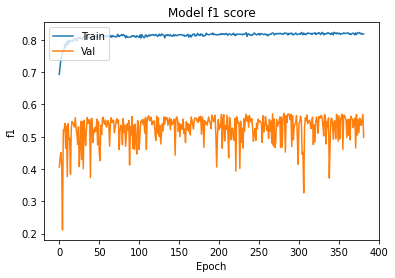

In [ ]:
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('Model f1 score')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend(['Train', 'Val'], loc = 'upper left')

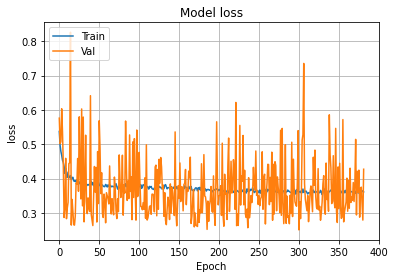

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇▇██████▇█████
loss,█▅▃▃▃▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▂
val_f1_score,▂▇▇▇▁▃▇▇▅▇▇▆█▅██▇▇█▇██▅▇█▅▇▇▅▄▄▂▇▇█▅█▇▇▇
val_loss,▇▂▁▁█▅▃▂▅▂▃▄▂▅▂▁▂▄▁▃▁▂▄▂▂▄▂▂▄▆▅▆▃▃▁▅▂▂▂▂
Accuracy,0.87709
F1,0.57237
G-Mean,0.78341
Precision,0.49493
Recall,0.67854
best_epoch,281


https://wandb.ai/mlops_ivan/bank_mlp/runs/15buqxk3

Epoch 132: early stopping
18-07-2022 12:46:04 Evaluation metrics
18-07-2022 12:46:04 Accuracy: 0.8646656134807793
18-07-2022 12:46:04 Precision: 0.46265328874024525
18-07-2022 12:46:04 Recall: 0.7211120764552563
18-07-2022 12:46:04 F1: 0.5636672325976231
18-07-2022 12:46:04 G-Mean: 0.7986241107722596
https://wandb.ai/mlops_ivan/bank_mlp/runs/16q023ea

## 4.2 Sweeps

In [ ]:
def train_func():

     # The sweep calls this function with each set of hyperparameters
    # Default values for hyperparameters
    defaults = dict(layer_1 = 32,
                layer_2 = 32,
                learn_rate = 0.001,
                batch_size = 512,
                epoch = 300,
                dropout1 = 0.9,
                dropout2 = 0.9,
                l2_1 = 0.0,
                l2_2 = 0.0,
                gradient_cliping = 2,
                bath_norm = 1)
    
    # Initialize a new wandb run
    wandb.init(project="bank_mlp", entity="mlops_ivan", config= defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Instantiate a simple classification model
# Instantiate a simple classification model
    # Instantiate a simple classification model
    model = tf.keras.Sequential()
    if config.l2_1!=0.0:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1.0:
      model.add(layers.BatchNormalization())
    if config.dropout1!=1.0:
      model.add(layers.Dropout(config.dropout1))
    if config.l2_2!=0.0:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1:
      model.add(layers.BatchNormalization())
    if config.dropout2!=1.0:
      model.add(layers.Dropout(config.dropout2))
    model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))
    
    
    # Instantiate a logistic loss function that expects integer targets.
    loss = tf.keras.losses.BinaryCrossentropy()

    # Instantiate an accuracy metric.
    # metric = tf.keras.metrics.BinaryAccuracy()
    metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

    # Instantiate an optimizer.
    if config.gradient_cliping==0.0:
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
    else:
        optimizer = tf.keras.optimizers.Adam( 
                                        learning_rate=config.learn_rate,
                                        clipvalue= config.gradient_cliping
                                        )

    # configure the optimizer, loss, and metrics to monitor.
    model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score, m_bacc_score])

    # early_stopping = callbacks.EarlyStopping(
    #             monitor='val_loss',   # 'loss'             
    #             min_delta=0.001, # Minimum change
    #             patience=100, # Number of epochs with no improvement
    #             verbose=1, # 
    #             mode='auto', # "auto", "min", "max"
    #             baseline=None, # Baseline value for the monitored quantity
    #             restore_best_weights=True) # restore weights epoch with best value

    early_stopping = callbacks.EarlyStopping(
                monitor='val_f1_score',   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

    model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
              y= y_train,
              batch_size=config.batch_size,
              epochs=config.epoch,
              validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val)
              callbacks=[
                          WandbCallback(monitor="val_f1_score",
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=0)
                        #  WandbCallback( monitor="val_f1_score",
                        #                 mode="max",
                        #                 validation_data=(x_val_encoded, y_val),
                        #                 save_model="True",
                        #                 log_weights=True),
                        #                 early_stopping],
                        #                 verbose=0 )

    
    y_pred = np.rint(model.predict(x_val_encoded)).ravel()

    # Evaluation Metrics
    fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
    precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
    recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
    acc = accuracy_score(y_val.values.ravel(), y_pred)
    g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

    # run.summary["Accuracy"] = acc
    # run.summary["Precision"] = precision
    # run.summary["Recall"] = recall
    # run.summary["F1"] = fbeta
    # run.summary["G-Mean"] = g_mean  
    # 
    metrics = { "val_accuracy": acc,
                "val_precision": precision,
                "val_recall": recall,
                "val_F1": fbeta,
                "val_G-Mean": g_mean
                }
    wandb.log(metrics) 

In [ ]:
# See the source code in order to see other parameters
# https://github.com/wandb/client/tree/master/wandb/sweeps

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'binary_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'layer_1': {
            'max': 64,
            'min': 16,
            'distribution': 'int_uniform',
        },
        'layer_2': {
            'max': 64,
            'min': 16,
            'distribution': 'int_uniform',
        },
        'learn_rate': {
            'min': -3,
            'max': -2,
            'distribution': 'log_uniform', #  log_uniform
        },
        'batch_size': {
            'values': [256,1024,4096,8192]
        },
        'epoch': {
            'values': [500]
        },
        'dropout1': {
            'values': [0.5,0.7,0.9,1.0] 
        },
        'dropout2': {
            'values': [0.5,0.7,0.9,1.0] 
        },
        'l2_1': {
            'values': [0.01,0.001,0.0001,0.0]  
        },
        'l2_2': {
            'values': [0.01,0.001,0.0001,0.0]  
        },
        'gradient_cliping': {
            'values': [0.0,0.5,1.0]
        },
        'bath_norm': {
            'values': [0,1]
        }
    }
}

# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'binary_accuracy',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'layer_1': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'layer_2': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'learn_rate': {
#             'min': -4,
#             'max': -2,
#             'distribution': 'log_uniform', #  log_uniform
#         },
#         'batch_size': {
#             'values': [32,128,256,1024,4096]
#         },
#         'epoch': {
#             'values': [200,300,500]
#         },
#         'dropout1': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'dropout2': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'l2_1': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'l2_2': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'gradient_cliping': {
#             'values': [0.0,0.5,1.0]
#         },
#         'bath_norm': {
#             'values': [0,1]
#         }
#     }
# }

In [ ]:
# Initialize a new sweep

sweep_id = wandb.sweep(sweep_config, entity="mlops_ivan", project="bank_mlp")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. learn_rate uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: oe8nm626
Sweep URL: https://wandb.ai/mlops_ivan/bank_mlp/sweeps/oe8nm626


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train_func,count=80)

wandb: Agent Starting Run: 7ecwo1vs with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 26
wandb: 	layer_2: 22
wandb: 	learn_rate: 0.0621053605225933
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▁▁▁▂▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇██▇██▇███████▇██▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆▅▁▁▂▆██▆▇▅▅▄▄▄▄▄▅▄▄▅▆▄▄▄▅▅▆▇▅▅▅▅▅▆▆▆▇▆▆
val_loss,█▆▂▁▁▁▁▂▃▃▄▄▆▇▆▆▆▆▇█▆▅▇█▇▆▅▅▃▅▇▅▅▅▃▄▄▃▄▄
val_precision,▁
val_recall,▁
best_epoch,9


wandb: Agent Starting Run: g2fijgz2 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 30
wandb: 	layer_2: 52
wandb: 	learn_rate: 0.06996813729003268
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,4


wandb: Agent Starting Run: il3vpkga with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 35
wandb: 	layer_2: 60
wandb: 	learn_rate: 0.09826400805546665
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 28.
Epoch 78: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▁▆▇▇▇██████████████████████████████████
loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂▁▄▆▇▇▇▆▇▇▇▆▇▇█▇█▇▇▇██▇██▇███▇▇▇▇▇▇▇▆▇██
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,27


wandb: Agent Starting Run: 1dpxqw3m with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 25
wandb: 	layer_2: 64
wandb: 	learn_rate: 0.12084052028447705
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▅█▆▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄
loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l5t5az2q with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 38
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.05582226756225878
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▆▄▅▄▆▁▆▅▄▂▂▅▄▆▅▅▂▅▂▂▃▃▄▃▄▅▆▁▄▅▁▄▆▆▄█▂
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: 320tp0hm with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 26
wandb: 	layer_2: 35
wandb: 	learn_rate: 0.1205758603203592
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▅▇█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▇▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tf1w7juj with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 53
wandb: 	layer_2: 49
wandb: 	learn_rate: 0.06739140563358716
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 82.
Epoch 132: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆▆▁▆▅▆▃▄▆▆▃▂▁▂▂▃▂▅▆▅▆▅▆▅▄▄▅▇▄▅▅▇█▅▅▆▆▅▅▅
loss,▃▄█▂▃▁▅▅▄▄▆▇▇▅▅▆▇▅▄▄▃▄▂▄▄▄▃▄▅▄▄▃▂▅▄▃▃▃▃▄
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▆█▆▁▆▆▃▇▇█▇▆▆▇▃▅▄▇▅▇▅▇▇█▆▇▆▇▇█▆▆▇▃▄▅▅▃▆
val_loss,▇▃▁▄█▃▄▆▂▁▁▂▄▃▂▇▅▁▃▄▂▅▃▂▂▄▃▄▄▂▁▄▄▃▆▅▅▄▆▄
val_precision,▁
val_recall,▁
best_epoch,114


wandb: Agent Starting Run: 94y3pd16 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 21
wandb: 	layer_2: 30
wandb: 	learn_rate: 0.0737261242555486
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▇█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,2


wandb: Agent Starting Run: 9uos4fzq with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 16
wandb: 	layer_2: 16
wandb: 	learn_rate: 0.10492945838632758
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁█████████████████▇██▇██▇██▇▇▇▇▇██▇██▇▇▇
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂▅▁▅▁█▇█▂▆▄▆▁▅▇▄▆▇▂█▄▇█▇▅▆▆▂▇▇▆▇▆▅▅▅▆▇▇▄
val_loss,▇▃▇▄▆▂▂▁▆▄▅▃▆▅▃▄▃▃▇▂▄▂▂▃▄▃▄█▂▂▄▁▃▄▅▃▃▂▂▁
val_precision,▁
val_recall,▁
best_epoch,32


wandb: Agent Starting Run: r5co8ewt with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 39
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.07114456311462934
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 26.
Epoch 76: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▃▂▆▁▅▃▄▆▆▆▇▄▄▃▄▃▁▄▄▃▃▄▇▅▅▄▅▅▅▆█▄▄▂▂▃▃▃▄▄
loss,▃▂▃▂▄▅▃▅▄▂▂▄█▄▅▅▆▄▄▄▂▂▄▂▃▁▂▁▃▂▃▃▃▃▄▂▂▃▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▇▂▂▃▆▄▆▇▆▆▆▆▁█▅▄▂▆▆▆▆▆▆▇▁▆▆▆▂▆▅▆▆▆▆▅▆▆▃▆
val_loss,▂▅▄▁▂▂▆▇▇▄▄▅▄▆█▄▃▅▄▅▄▅▃▄▃▃▁▃▃▅█▂▄▃▆█▄▄▅▄
val_precision,▁
val_recall,▁
best_epoch,25


wandb: Agent Starting Run: 9k4mgvys with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 22
wandb: 	layer_2: 59
wandb: 	learn_rate: 0.08055430695918156
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇█▇█▆█▇▇▇█▇▆▆▇▇▇▇▇▆▇▇▇▇▇▆▇██▆▆▇▆▇█▇▇▇
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▄▆▆▇▆▄▆▇▇▇▇▆▇▇▇▆██▇▅██▇▇██▇▆▁▅▅▇█▇▇█▅██▇
val_loss,▃▅▃▄▃▅▂▃▄▂▃▂▃▄▄▆▃▄▅▅▃▃▄▄▄▃▅▁█▆▅▄▂▅▂▃▆▂▃▄
val_precision,▁
val_recall,▁
best_epoch,32


wandb: Agent Starting Run: hi3sru3h with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 19
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.09281427239262637
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▆▁▅▆▃▅▃▄▅▅▇▅█▅▅▄▃▄▆▅▄▄▆▆▂▄▄▅▅▄▄▇▄▄▅▅▅▇▆▆
loss,▃▁▂▂▃▁▃▄▂▂▁▃▄▄▄█▅▃▃▂▂▃▄▃▂▂▁▃▃▁▂▄▂▁▂▂▃▃▄▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁█▂▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▅▁
val_loss,▂▃▆▃▄▂▃▂▂▄▁▂█▄▃▆▅▇▃▄▁▃▃▅▅▃▃▄▄▁▄▂▃▂▂▄▅▅▃▅
val_precision,▁
val_recall,▁
best_epoch,2


wandb: Agent Starting Run: vg4m5kw8 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 32
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.12432851084710944
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▄▅▄▃▃█▆▆▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▃▂▁▁▁▁▂▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: y8923ayx with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 47
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.056378858774434215
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 50.
Epoch 100: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁██▇█████████████▇███▇█▇▇▇███▇▇███▇▇▇▇▇▇
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▂▂▁▁▁▂▁▁▂▁▂▂▂▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▄█▅▃█▇▅▆▆▅▂▄▆▄▇▆▅▆▆▇▇▆▄▃▅▂▅▆▁▃▆▄▅▆█▅█▆▅
val_loss,▃▃▂▂▆▁▁▄▁▂▃▆▆▃▆▃▂▃▄▄▂▂▃▅▆▃█▃▃█▇▃▄▄▃▃▄▁▄▆
val_precision,▁
val_recall,▁
best_epoch,49


wandb: Agent Starting Run: lnk65s21 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 25
wandb: 	layer_2: 45
wandb: 	learn_rate: 0.06952246632238152
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 71.
Epoch 121: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▅▆▆▇▇▇▇▇▇▇▇██████▇█████████▇██████████
loss,█▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▄▃▃▇▁▂▆▇▇▇▇▆▆▇▆███▇▆▃▇▆██▇▇▇██▇▃▆▇█▂▇█▇█
val_loss,▅▇█▂▁█▄▂▃▂▁▄▄▃▃▁▂▂▃▅▆▁▃▂▁▂▃▃▁▂▃█▄▃▂▇▂▁▂▂
val_precision,▁
val_recall,▁
best_epoch,70


wandb: Agent Starting Run: 1y0suajv with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 60
wandb: 	layer_2: 59
wandb: 	learn_rate: 0.1073633975260144
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▄▆▆▇▇▇▇█▇████████████████████████████▇
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▂▁▂▄▆█▃▅▆▆▆▆▆▅▅▅▆▅▆▆▆▅▅▅▅▅▄▆▅▆▄▆▃▅▆▆▆▄▅
val_loss,█▃▂▁▁▁▁▁▁▂▂▂▃▂▃▃▃▁▂▂▂▂▂▃▂▂▃▄▂▄▃▄▂▅▃▂▃▂▄▃
val_precision,▁
val_recall,▁
best_epoch,6


wandb: Agent Starting Run: k2e1g6h7 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 47
wandb: 	layer_2: 41
wandb: 	learn_rate: 0.08173367481663127
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▆█▇▇▇▇▆▆▇▆▆▆▆▄▅▅▄▆▁▆▃▅▆▆▅▄▅▄▅▆▆▅▆▇█▆▇▅▇
loss,█▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▁▁▁▂▁▂▂▂▂▁▂▂▂▁▂▂▂▂▁▁▂▁▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▄▃█▆▇▇▇▆█▇▄▇▇▃▇▆▇▂▆▇▇▇▆█▆▇▅▇▇▃█▇▅▇█▇▇██
val_loss,▂▇▂▁▄▃▁▃▃▂▃█▂▄▂▄▄▃▁▄▁▁▃▆▁▆▂▆▂▄▇▁▂▅▂▂▃▃▂▃
val_precision,▁
val_recall,▁
best_epoch,11


wandb: Agent Starting Run: 8269qzlg with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 39
wandb: 	layer_2: 48
wandb: 	learn_rate: 0.0956277071288563
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 139.
Epoch 189: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆▁▃▆▆▇▇▇▇▇▇▇▇▇▇█▇██████████▇▇███▇▇▇▇▇█▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▃▇▆▄▆▆▆▆▇▇▇▇▇█▇▇█▇█▇█▇██████▇████████▇
val_loss,█▅▄▅▆█▆▆▆▆▄▅▅▁▃▃▃▃▃▄▃▃▃▄▃▃▂▂▃▄▃▃▂▂▂▂▂▂▂▁
val_precision,▁
val_recall,▁
best_epoch,138


wandb: Agent Starting Run: 4m4d5ajb with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 23
wandb: 	layer_2: 16
wandb: 	learn_rate: 0.082029714661786
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 16.
Epoch 66: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▄▁▂▅▄▅▅▅▆▆▅▇▆▆▆▅▅▆▆▇▅▅▅▆▇█▇███▇▇▆▇▇█▇▇▆▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▁▄▇▆▆▇▆▆█▆▆▆▆▆▆▆▆▆▆▆▁▅▇▅▅▅▆▅▆▆▆▆▅▇▆▆▆▇▇
val_loss,█▂▂▁▂▁▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▃▄▄▃▃▂▂▂▂▃▃▂▁▂▁▃
val_precision,▁
val_recall,▁
best_epoch,15


wandb: Agent Starting Run: vcflwoom with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 54
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.07596942314264259
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▇█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,1


wandb: Agent Starting Run: 46wn6dwn with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 29
wandb: 	layer_2: 20
wandb: 	learn_rate: 0.12968223073074936
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,3


wandb: Agent Starting Run: bhxhpqpg with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 58
wandb: 	learn_rate: 0.0770362069249872
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 48.
Epoch 98: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,47


wandb: Agent Starting Run: 30jf7c5z with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 47
wandb: 	layer_2: 64
wandb: 	learn_rate: 0.12898831271737318
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆█▃▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Agent Starting Run: wpieaqeo with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 44
wandb: 	layer_2: 31
wandb: 	learn_rate: 0.10977248227014703
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 40.
Epoch 90: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇▆▆▆▇▆█▆▅▆▇▇▇▆▅▇▆▆▇▇▆▅▆█▆█▆▅▆▅▆▅▆▇▇▇▇
loss,█▁▂▂▂▃▄▁▃▂▃▅▄▂▃▃▂▇▃▇▄▄▅▄▆▃▂▂▂▂▄▄▂▅▂▃▂▁▃▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆▂▄▄▆▄▃██▇▅▇▅█▇▇▅▇█▅█▁█▄▇█▆▆▆▅▂▅▆▆█▇▄▅▅▇
val_loss,▆▅▂▁▃▂▅▂▂▂▁▂▄▂▂▃▂▂▃▅▃█▂▃▄▂▂▄▁▂▁▄▂▂▂▁▁▁▄▃
val_precision,▁
val_recall,▁
best_epoch,39


wandb: Agent Starting Run: ekfjx787 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 29
wandb: 	layer_2: 48
wandb: 	learn_rate: 0.07409025768612375
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 112.
Epoch 162: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇▇▇▇▇▇▇▇▇▇███▇▇██▇▇███▇████▇████████
loss,█▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂▄▅▅▆▆▆▆▃▇▆▆▇▇▇██▆▆▆▂▁▇██▅▃█▆█▇▅▄▇█▇██▇▆
val_loss,█▇▄▂▂▃▂▃▃▁▂▂▂▂▂▁▂▄▃▂▅▅▁▁▁▃▄▁▃▂▂▃▃▂▁▂▁▁▁▃
val_precision,▁
val_recall,▁
best_epoch,111


wandb: Agent Starting Run: gefqh0ja with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 23
wandb: 	layer_2: 62
wandb: 	learn_rate: 0.071950232611917
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▇█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,1


wandb: Agent Starting Run: 1aiid2g9 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 43
wandb: 	layer_2: 25
wandb: 	learn_rate: 0.11351899144106437
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▄▃▂▄▃▂▂▂▃▂▄▂▂▁▃▃▃▆█▇█▇▇▇▆▅▇▆▇▆▅▇▆▇▇▇▇▇
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: g3j3c0pb with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 61
wandb: 	layer_2: 26
wandb: 	learn_rate: 0.06880621522185651
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▃▃▃▃▂▂▁▂▂▁▂▁▂▇▆▇██▆▆▆▆▅▅▄▅▄▄▄▅▄▄▃▄▃▄▃▃
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: jp74r3z5 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 17
wandb: 	layer_2: 49
wandb: 	learn_rate: 0.07524781077467031
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▂▂██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: 7x9z1384 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 53
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.12190206758958907
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▃▁▃▅▇▇▇▇████████████████████████████████
loss,█▅▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▃▃▆█▆██▇▇▇▆▆▇▆▆▆▅▆▆▆▇▇▅▆▆▆▄▅▅▄▃▃▃▄▃▄▅▆▆
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▂▂▂▂▂▂▁▁▁
val_precision,▁
val_recall,▁
best_epoch,9


wandb: Agent Starting Run: wyt0a6l9 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 49
wandb: 	layer_2: 64
wandb: 	learn_rate: 0.08629685889608939
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: vkhbpdxp with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 48
wandb: 	layer_2: 47
wandb: 	learn_rate: 0.07762902890792107
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 119.
Epoch 169: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▆▇▇▇▇▇█████████████████████████████████
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▃▅▄▅▂▃▇▇▅▄▆▇▄▆▆▆▇▇█▇▇▇▇▇▇▆█▇▇▇███▇█▇█▇
val_loss,▆█▅▃▃▃▄▃▂▁▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,118


wandb: Agent Starting Run: ghyij6o2 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 38
wandb: 	layer_2: 34
wandb: 	learn_rate: 0.058447690913760855
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Agent Starting Run: rakp0nbw with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 57
wandb: 	layer_2: 48
wandb: 	learn_rate: 0.10516387123559374
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▃▁▂▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▇▇▇██▇▇██▇▇
loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▂▂▁▂▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▆▆█▆█▂▁▆▆▆▅▅▆▆▇▅▅▅▅▅▇▇▆▅▇▅▅▅▄▄▄▄▄▆▆▄▇▄▆
val_loss,▇▂▄▂▂▂▁▁▁▁▁▂▂▁▂▃▁▁▁▂▁▃▃▂▂▂▂▂▂▅▅█▅▅▄▄▆▃▄▃
val_precision,▁
val_recall,▁
best_epoch,4


wandb: Agent Starting Run: 5y6dhwtl with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 30
wandb: 	layer_2: 25
wandb: 	learn_rate: 0.08923784817102691
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: unlvtwaa with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 17
wandb: 	layer_2: 34
wandb: 	learn_rate: 0.06934931317310776
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▂▁▃▁▂▂▂▂▃▂▄▅▃▂▃▃▂▃▄▃▅▃▇▂▂▂▄▄▂▂▂▂▁▂▂▂▃█
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: im35r7bz with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 32
wandb: 	layer_2: 60
wandb: 	learn_rate: 0.09352873372675666
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: 0ajah0u0 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 56
wandb: 	layer_2: 32
wandb: 	learn_rate: 0.06118040655239894
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▄▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▅▇███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Agent Starting Run: uerd8dlc with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 20
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.09078655006066048
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▇███▇▇▆▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Agent Starting Run: kfgxyx52 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 60
wandb: 	layer_2: 27
wandb: 	learn_rate: 0.06974923530436658
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 33.
Epoch 83: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▆▃▅▆█▆▄▅▄▄▃▃▃▆▄▃▇▂▄▅▄▁▂▃▃▁▃▂▃▆▂▃▃▂▄▃▄▃▂
val_precision,▁
val_recall,▁
best_epoch,32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q2ydjb02 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 19
wandb: 	layer_2: 52
wandb: 	learn_rate: 0.058852266355402943
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 59.
Epoch 109: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▅▇▇█▆▇▆▇▇▇▇▇▇▆█▆▇▇▆▇▇▆▇▇▆▇▇█▇▇▇▇▇██▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▄▁▃▅▂▇▇▅▇▆▇▇▇▇▇▇▇█▇▆█▇▅▇▇▇▅▇▅▆▆▄▆▆▆▆▇▄▆
val_loss,█▃▁▁▂▂▂▃▂▃▃▂▂▂▂▂▁▂▃▃▁▂▂▁▃▂▂▁▃▁▄▁▄▂▂▄▃▂▅▁
val_precision,▁
val_recall,▁
best_epoch,58


wandb: Agent Starting Run: 2ie0drzw with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 46
wandb: 	layer_2: 49
wandb: 	learn_rate: 0.11398013436046509
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dvc13xyq with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 56
wandb: 	layer_2: 58
wandb: 	learn_rate: 0.11411048301234468
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▃▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇██████████
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▃▂▂▃▄▁▄▆▆█▇▆▄▅▇█▆▅▆▆▆▆▆▅▄▄▆▆▃▄▄▆▆▇▁▇▅▇▇
val_loss,█▃▃▂▃▄▇▅▄▃▃▃▃▄▄▄▃▄▄▁▂▃▂▂▃▅▄▁▁▃▃▂▁▁▂▇▃▁▁▂
val_precision,▁
val_recall,▁
best_epoch,16


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zwug7ku3 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 57
wandb: 	layer_2: 55
wandb: 	learn_rate: 0.10813743487184029
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▃▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,6


wandb: Agent Starting Run: yhjolqp5 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 17
wandb: 	layer_2: 17
wandb: 	learn_rate: 0.05394651926791923
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
epoch,50


wandb: Agent Starting Run: 470ai4g4 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 23
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.094746267056611
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 70.
Epoch 120: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▆▇▇▇▇▇▇▇▇█▇█████▇████████▇█▇▇█▇███████
loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▁█▅█▆██▇█▆▇▆▅▆▇▅██▅██▆█▇██▆█▆█▆▇▇▆█▆███
val_loss,█▂▁▅▁▄▂▁▁▂▄▂▄█▄▃▆▂▁▇▂▂▄▂▂▃▁▄▂▅▂▅▃▃▅▂▅▂▁▁
val_precision,▁
val_recall,▁
best_epoch,69


wandb: Agent Starting Run: olrbkjuz with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 27
wandb: 	layer_2: 18
wandb: 	learn_rate: 0.1269943070093612
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▁▁▄▄▂▂▁▁▁▁▁▁▁▁█▄▃▂▂▃▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▂▁█▁▁▁▁▁▁▁▁▁▁▄▇▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,4


wandb: Agent Starting Run: 0wthuouy with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 61
wandb: 	layer_2: 36
wandb: 	learn_rate: 0.0707509076714634
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 106.
Epoch 156: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▆█▇▇▆▄▄▂▃▃▃▄▄▄▄▅▅▄▃▅▃▂▃▁▂▁▂▅▃▃▃▅▆▃▃▄▅▃▃▃
loss,▄▁▃▂▃▅▆▆▅▇▅▅▇▅▃▄▄▄▄▆▆▇▆▇▆█▆▄▅▅▆▅▄▆▅▃▄▅▅▆
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆▄▃▅▄█▆▇▅▅▅▅▇▂█▇▅▆▅▂▅▇▅▆█▅▁▆▆▄▅▄▆▆▄▄▄▅▇▅
val_loss,▁▂▄▂▄▃▄▂▅▄▅▆▃▆▂▄▅▃▃▇▄▅▄▄▁▅█▄▃▆▄▅▃▅▅▇▆▆▂▄
val_precision,▁
val_recall,▁
best_epoch,105


wandb: Agent Starting Run: j7h9nvpe with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 51
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.05439134547918411
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 27.
Epoch 77: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▃▅▆▅▆▆▆▆▅▆▆▇▆▇▆▆▆▇▇▆▇▇▇▇█▇▇▇▇▆▇▇▆▆▇▆▇▇
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▁▂▂▁▂▂▂▂▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▃▃▃▄▁▆▄▇▇▆▇▇█▇▇██▇█▇▇██▇████████████▆█▇
val_loss,▅▄▅▄▄█▄▆▃▃▄▂▃▃▂▃▃▂▂▃▂▁▂▁▄▂▂▃▃▂▃▂▂▂▃▂▂▁▁▃
val_precision,▁
val_recall,▁
best_epoch,44


wandb: Agent Starting Run: qxudowfz with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 58
wandb: 	layer_2: 26
wandb: 	learn_rate: 0.13118414658362595
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▃▅▄▄▃▂█▂▃▅▃▁▄▁▄▃▂▄▂▄▃▃▂▁▃▄▃▄▃▄▁▃▅▅▃▃▄▅▅▃
loss,█▂▂▂▂▃▁▂▁▂▂▃▁▂▂▁▂▂▃▃▁▃▂▄▂▁▂▁▂▂▃▂▃▂▃▂▃▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▃▁▅▆▃▆▆▇▇▅▅▄▇▆▅▇▆▄▅█▅▇▅▂▆▆▃▃▅▆▇▅▆▄▇▅▇▂▃
val_loss,▁▃▇▅▂▂▂▃▄▃▆▄▅▄▁▅▂▃▅▄▁▂▂▄█▄▅█▆▃▂▃▄▃▇▃▂▂▁▇
val_precision,▁
val_recall,▁
best_epoch,52


wandb: Agent Starting Run: 5jtphfj3 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 19
wandb: 	layer_2: 41
wandb: 	learn_rate: 0.06479226401021722
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 66.
Epoch 116: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▇█████████████████████████████████████
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▃▅▇▄▅▄▅▅█▆▅▆▆▆▅▇▇▆▇▆▆██▇█▆▆███▇█▇█▇██▅▇
val_loss,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▂▁
val_precision,▁
val_recall,▁
best_epoch,65


wandb: Agent Starting Run: 3ezllyap with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 49
wandb: 	layer_2: 57
wandb: 	learn_rate: 0.1109666678393533
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 77.
Epoch 127: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▄▄▄▅▅▄▅▆▇██▇▇█▇█▇▇▇████▇███▇██▇████▇▇▆▆
val_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,76


wandb: Agent Starting Run: tt9k9jga with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 28
wandb: 	layer_2: 50
wandb: 	learn_rate: 0.0669917756425548
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 120.
Epoch 170: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇█▇█▇█▇████████▇▇▇▇▇▇▇█▇██████▇██▇█████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▂▁▅▅▄▅▇▅▇▇▇▅▄▇▇▅▇▇▇▇▆▇▇█▇▅██▇▇▇▇▆▅█▆▆▇▇
val_loss,▅▇█▅▅▆▅▁▅▃▂▃▄▅▃▃▄▄▃▃▃▄▂▁▂▃▅▁▂▃▃▂▂▄▄▂▄▃▂▃
val_precision,▁
val_recall,▁
best_epoch,119


wandb: Agent Starting Run: m66ty5p4 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 39
wandb: 	layer_2: 31
wandb: 	learn_rate: 0.1042537024859166
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 69.
Epoch 119: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁█▆▁▁▁▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,68


wandb: Agent Starting Run: hkhcjna9 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 41
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.08280428165003531
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 126.
Epoch 176: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▃▃▄▂▂▃▃▂▃▃▅▄▄▅▆▄▄▅▅▅▆▆▇▇▇▇▇███▇▇██████
loss,█▇▇▆▆▇▇▆▇▆▆▆▄▅▅▄▃▅▅▄▅▄▃▃▃▃▂▂▂▁▂▁▂▂▂▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆▆▆▆▆▅▄▆▁▅▇▇▇▇█▇▇▇▆▆█▆▇▇▅▆▇▇█▇█▆▇██▇█▇▇█
val_loss,█▄▃▅▄▅▄▅▂▄▃▃▄▅▃▁▁▄▄▅▃▂▄▄▆▇▄▅▅▅▅▆▃▃▃▆▂▄▆▆
val_precision,▁
val_recall,▁
best_epoch,125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: orwpgnx8 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 47
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.10747012095623132
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 89.
Epoch 139: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇▆█▇▇▇██▇█▇███▇████▇
loss,█▇▆▆▅▅▅▄▄▄▄▃▃▂▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▄▄▆▆▇▆▇▇▆▆▇▇▇▇▇▇▅▇▆█▇▇▇▇▇█▇▆▇▆▇▇███▆▅█▇
val_loss,██▆▂▂▄▄▃▂▁▄▃▃▃▃▃▂▅▂▂▂▅▂▁▁▃▃▃▄▃▄▃▃▁▃▂▄▆▃▂
val_precision,▁
val_recall,▁
best_epoch,88


wandb: Agent Starting Run: ubbp39ym with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 64
wandb: 	layer_2: 62
wandb: 	learn_rate: 0.0532634154172307
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,0


wandb: Agent Starting Run: fdwd7p7a with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 53
wandb: 	layer_2: 32
wandb: 	learn_rate: 0.05925256873977276
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 58.
Epoch 108: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▆▇▇████▇▇█▇█▇█▇███████████████████████
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▂█▇▇▆▅█▅▆▄▇▇▇▇▇▇▇▆▇▇██▆▆▆▆▆▆▆▇█▇▇▇▇▆▇▆█
val_loss,█▂▂▂▂▃▃▂▃▃▃▁▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▃▂▂▁▁▂▂▁▂▂▂▂▂
val_precision,▁
val_recall,▁
best_epoch,57


wandb: Agent Starting Run: lhxgil0o with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 54
wandb: 	layer_2: 58
wandb: 	learn_rate: 0.05034991445358784
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,██▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,1


wandb: Agent Starting Run: h5xkb1s8 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 53
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.10295203112375044
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,1


wandb: Agent Starting Run: 1kjly6p3 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 20
wandb: 	layer_2: 42
wandb: 	learn_rate: 0.050344759963352664
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 285.
Epoch 335: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████▇████▇█████
loss,█▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▅▆▅▆▅▆▇▆▇▇█▇▇▇█▇██▇████████████████▆███
val_loss,█▇▆▆▅▇▅▄▄▄▃▄▃▂▄▃▄▃▂▅▂▃▃▃▃▂▂▂▂▂▂▁▂▃▁▃▅▃▃▂
val_precision,▁
val_recall,▁
best_epoch,284


wandb: Agent Starting Run: 4ie08flr with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 17
wandb: 	layer_2: 56
wandb: 	learn_rate: 0.06630549613158812
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▄▇▄▃▁▂▁▂▁▁▂▂▁▁▁▁▂▁▁▂▂▁▁▂▁▃▁▁▁▁▁▂▂▂▁▂▁
val_precision,▁
val_recall,▁
best_epoch,2


wandb: Agent Starting Run: n2rnz8mx with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 63
wandb: 	layer_2: 17
wandb: 	learn_rate: 0.11631021833560536
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▃▄▃▄▄▅▅▅▄▄▅▆▇▅▃▅▅▆▆▆▅█▇▇▇▇▄▇▆▇▆█▇▆▇▇█▆
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▃▂▂▃▃▂▂▂▂▂▃▃
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▇▇▅▆▇▇▇█▄▅▆▇▇▇▄▇▇▄▇▃▇▂▂▄▄▆▁▁█▆▃▅▇▆▄▆▆▆▃
val_loss,█▁▂▂▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▂▂▁▂▁▂▂▂▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,13


wandb: Agent Starting Run: 6yfgg79s with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 38
wandb: 	layer_2: 60
wandb: 	learn_rate: 0.061095502794643416
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 35.
Epoch 85: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▆▇▇▇▇▇█████████▇█████▇█████████████▇██
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▂▁▆▄▇▂▃▆▇▆█▇▇▇▇█▇▇▇▇▇██████▅▇▅▇██▇█▇▇▇█
val_loss,█▇▅▂▃▂▄▄▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▂▁
val_precision,▁
val_recall,▁
best_epoch,56


wandb: Agent Starting Run: 997qehcx with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 62
wandb: 	layer_2: 25
wandb: 	learn_rate: 0.09381157408859488
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 42.
Epoch 92: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇▇▇▇▇▇████▇████▇█▇█▇█▇▆▇▇██▇▇▇▇▇███▇█
loss,█▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▂▄▄▂▆▆▂▆▇█▇▆▄▅█▅▆▇▄▆█▇▅▁▁▅▆▆▂▄▄▅▇▅▇▆▇▇▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,41


wandb: Agent Starting Run: lw3yqhju with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 42
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.08041007242068408
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
f1_score,▁▅▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇█▇████▇▇▇▇█▇▇▇▇▇█
loss,█▄▂▂▁▂▂▁▁▁▂▂▂▂▂▁▂▂▂▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▄▇▆▇▇▇▇█▇█▆▇████▇▇▇▆▇█▇▇▇█████▇██▅▇██▇▇
val_loss,█▅▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▁▁▂▁▂▂▃▁▂▂▂▂
val_precision,▁
val_recall,▁
best_epoch,12


wandb: Agent Starting Run: s2ms0ttg with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 42
wandb: 	layer_2: 26
wandb: 	learn_rate: 0.05184028711596875
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 130.
Epoch 180: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▃▃▂▁▂▃▄▅▅▄▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████
loss,█▇▇▆▇▇▇▆▅▅▄▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▅▆▆▆▇▇▄▆▆▇▇█▄▅▇▃▇█▄█▄█▇█▆▇█▇██▆█▇▇███▇▇
val_loss,█▄▂▃▅▅▄▅▄▃▄▁▂▅▄▂▅▂▂▅▁▅▁▃▂▃▃▂▃▂▁▄▂▃▃▂▂▁▁▂
val_precision,▁
val_recall,▁
best_epoch,129


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 16fqmffl with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 44
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.096328554025164
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 63.
Epoch 113: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▆▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇█████▇█████▇██████
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂▄▃▆▇▇▇▅▆▄▄▆▇▅▇▇▆▆▅▇▇▁▄▄▁▅▃▇████▇▅▇███▆▇
val_loss,▆█▅▂▁▁▁▁▁▄▃▁▁▁▁▁▁▁▂▁▂▅▂▃▅▂▃▁▁▁▁▁▁▂▁▁▁▁▂▁
val_precision,▁
val_recall,▁
best_epoch,62


wandb: Agent Starting Run: mhbxiy9v with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 54
wandb: 	layer_2: 63
wandb: 	learn_rate: 0.05786457274741176
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 114.
Epoch 164: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▆▆▂▅▃▅▅▆▇▇▇▇▇▇▇█▇▇█████▇████████▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▂▄▂▃▁▃▁▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▆█▇▇▇▇
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,114


wandb: Agent Starting Run: wwkqh87j with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 27
wandb: 	layer_2: 31
wandb: 	learn_rate: 0.09584448390495096
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 87.
Epoch 137: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇▇▇█████████████████████████████████
loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▆▂▄▁▂▁▅▅▅▄▄▆▄██▇█▇▇▆▆▆▆▇▆▇▇▇█▇█▇▇█▆█▇██▇
val_loss,▃█▄▆▅▅▃▃▃▃▄▂▃▁▁▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▂▁▂▁▁▂
val_precision,▁
val_recall,▁
best_epoch,86


wandb: Agent Starting Run: rk25fvg2 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 17
wandb: 	layer_2: 32
wandb: 	learn_rate: 0.07562832845192247
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇█████████████
loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▄▇▆▅▇▁▂▂▅▅▃█▆▇█▆▆▄▆▄▃▇▆▆▆▂▇▇▆▆▄▇▄▆▅▇▅▂▅▇
val_loss,▃▁▁▂▁█▇▆▃▂▆▂▁▁▁▂▁▃▂▂▇▁▂▂▂▇▂▂▂▂▅▃▃▂▃▃▄▆▄▃
val_precision,▁
val_recall,▁
best_epoch,55


wandb: Agent Starting Run: xfqq9m9u with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 37
wandb: 	layer_2: 18
wandb: 	learn_rate: 0.09868184882909872
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▃▅▆▂▆▅▄▇▅▆▃▅▅▅▄▅▇▇▇▅█▇▇█▆▇▆▅▄▄▆▁▅▄▇▅▅▄▄
loss,▂▂▂▃▂▂▁▂▄▄▂▂▃▂▂▆▂▃▂▇█▃▄▂▁▄▃▂▂▃▁▁▂▂▁▁▅▂▂▃
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▁▁▆▆▁▁█▄█▁▁▆▆▁▁▁█▂▁▁▁▁▂▁████▁▃▁▅▁▇▁▁▁█▂
val_loss,▂▄▃▃▄▂▂▃▃▅▂▃▅▃▃▂▂▄▆█▅▄▃▄▃▄▃▂▃▃▂▂▃▂▃▁▄▂▃▃
val_precision,▁
val_recall,▁
best_epoch,10


wandb: Agent Starting Run: nwjjgi36 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 55
wandb: 	layer_2: 63
wandb: 	learn_rate: 0.05137764713200059
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 24.
Epoch 74: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▇█████████████████████████████████████
loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▁▅▇▇▇▇█▇██▇██▇███▇█▇█▇██▅▇▇▆▇█▅▇▅▇▇▆▇▆▇
val_loss,▄█▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁▂▂▁▁▂▁▂▁▁▂▂▂▂
val_precision,▁
val_recall,▁
best_epoch,43


wandb: Agent Starting Run: a7pzhkts with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 51
wandb: 	layer_2: 35
wandb: 	learn_rate: 0.07065986385746288
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 112.
Epoch 162: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇███▇█▇████▇███████████▇██▇██▇███████
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▁▆▂▆▁▅▄▆▇▆██▆█▇▇▇█▆▆▇▇▇▇█▇▅█▇▇▇█▆█▆▇▇▇▃▇
val_loss,█▅▃▄▃▂▅▂▃▂▃▂▄▂▃▃▂▂▄▁▃▂▂▂▂▁▄▂▃▂▂▂▁▂▁▃▂▂▁▂
val_precision,▁
val_recall,▁
best_epoch,111


wandb: Agent Starting Run: olp6vw61 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 34
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.0577827850414318
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 14.
Epoch 64: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▂▁▃▂▄▇▄█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▅▄▃▄▃▃▄▄▃▂▃▄▂▃▃▃▄▃▃▃▃▂▃▂▂▄▄▁▄▂▂▂▄
val_precision,▁
val_recall,▁
best_epoch,13


wandb: Agent Starting Run: 7d95f6v0 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 35
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.11164302553331357
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 49.
Epoch 99: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄█▄▄▅▆▅▆▆▅▄▄▅▅▅▅▅▄▄▇▅▆█▇▃▄▄▆▅▄▅▆▇▆▆▆▆▆▃▁
loss,█▃▄▆▃▄▂▂▃▁▂▂▃▂▄▁▂▂▂▂▃▁▃▂▂▅▃▅▂▃▃▂▂▁▃▂▂▂▂▃
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▄▅▇▆▇▆▇▇▇▇▅▅▇▅▆▇▇▆▇█▇▄▇▆▆▆▆▆▆▇▆▆█▇▅▇▁▇▇▆
val_loss,▃▃▂▁▂▁▃▃▁▃▂▇▂▅▂▃▃▁▁▁▁▅▄▃▃▄▄▄▄▄▄▃▁▂▃▄█▃▃▃
val_precision,▁
val_recall,▁
best_epoch,80


wandb: Agent Starting Run: 07wffgtj with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 64
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.11461161193751895
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▇█▆▇██▇▇███▇▆▇▇▇▇▇▇▇████▇▇█▇▇▇▇█▆▆▆█▇▇▇
loss,█▃▁▃▂▃▂▃▂▂▂▁▂▃▂▁▃▃▃▂▂▂▂▁▂▂▂▂▂▁▂▃▃▃▄▄▂▃▃▃
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▅▅▇▃▆▆▆▆▆▆▇█▇█▅▆▇▆▇▁▇█▄▅▆▇▆▆▅▅▇▇▇▇▆▄▇▇█▃
val_loss,▇▅▃▆▃▄▂▄▂▄▃▂▁▂▄▅▂▄▃█▃▃▆▆▁▂▄▅▅▅▃▂▃▃▅▁▂▃▄▇
val_precision,▁
val_recall,▁
best_epoch,19


wandb: Agent Starting Run: zq0vn509 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 18
wandb: 	layer_2: 63
wandb: 	learn_rate: 0.05370447577851586
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▇█▆▁▂▁▁▁▁▁▂▂▁▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▇▆█▁▁▁▁▁▁▂▅▁▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁
val_recall,▁
best_epoch,2


wandb: Agent Starting Run: teq3l57g with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 36
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.08982554716651589
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 96.
Epoch 146: early stopping


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▅▇▇▇▇▇▇▇▇▇████████████████████████████
loss,█▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▃▃▆▆▅▅▂▃▅▃▂▁▃▅▄▇▇▇▆▇▆▇▅▁▆▇▇▆▆██▇▆▇▇▇▅█▇▆
val_loss,█▄▂▂▄▃▆▆▄▅▅▇▅▃▄▁▂▂▂▂▃▁▃▅▂▂▂▂▃▁▁▂▂▂▂▁▃▁▂▂
val_precision,▁
val_recall,▁
best_epoch,120


wandb: Agent Starting Run: 17pg9eep with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 34
wandb: 	layer_2: 53
wandb: 	learn_rate: 0.06315353949997306
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 18.
Epoch 68: early stopping


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▆▆▇█▇▆▆▄▄▅▆▄▄▆▄▂▂▆▆▅▅▆▆▅▅▃▅▃▄▂▃▄▃▄▂▃▃▄
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▂▂▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_f1_score,▄▃▅▆▅▄▆▅▆▂█▇▅▆▄▆▄▁▂▅▅▇▂▅▅▃▄▄▃▂▅▅▄▄▄▃▁▂▃▂
val_loss,▆▆▃▆▃▁▄▃▅▄█▆▄▅▆▅▄▆▆▆▂▆▃▄▄▄▆▃▄▅▆▆▆▇▇█▄▃▄▆
val_precision,▁
val_recall,▁
best_epoch,17


In [ ]:
run.finish()


In [ ]:
b=testacas

### 4.2.1 Restore a model

Restore a file, such as a model checkpoint, into your local run folder to access in your script.

See [the restore docs](https://docs.wandb.com/library/restore) for more details.

In [ ]:
!wandb login

In [ ]:
# restore the raw model file "model-best.h5" from a specific run by user "ivanovitchm"
# in project "lesson04" from run "sqdv5ccj"
best_model = wandb.restore('model-best.h5', run_path="ivanovitchm/week06/cbwfq70j")

In [ ]:
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
# execute the loss and accuracy using the test dataset
loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=64)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

In [ ]:
# source: https://github.com/wandb/awesome-dl-projects/blob/master/ml-tutorial/EMNIST_Dense_Classification.ipynb
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = np.greater_equal(model.predict(test_x),0.5).astype(int)
cm = confusion_matrix(y_true = test_y, y_pred = predictions)

plt.figure(figsize=(6,6));
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
wandb.init(project="week06")
wandb.log({"image_confusion_matrix": [wandb.Image('confusion_matrix.png')]})

In [ ]:
# visualize the images and instances with error
# ground-truth
print("Ground-truth\n",test_y[~np.equal(predictions,test_y)])

# predictions
print("Predictions\n",predictions[~np.equal(predictions,test_y)])

In [ ]:
# Images predicted as non-cat
fig, ax = plt.subplots(2,6,figsize=(10,6))
wrong_images = (~np.equal(predictions,test_y)).astype(int)
index = np.where(wrong_images == 1)[0]

for i,value in enumerate(index):
  ax[i//6,i%6].imshow(test_x[value].reshape(64,64,3))
plt.savefig('wrong_predictions.png', bbox_inches='tight')

In [ ]:
wandb.log({"wrong_predictions": [wandb.Image('wrong_predictions.png')]})

## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipe),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
# pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
# pipe.set_params(**{"classifier__criterion": 'entropy'})
# pipe.set_params(**{"classifier__splitter": 'random'})
# pipe.set_params(**{"classifier__max_depth": 6})
# pipe.set_params(**{"classifier__random_state": 41})

pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__class_weight": {0:1.0, 1:6.0}})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipe.transform(x_train),
                              full_pipe.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

## 1.8 Export the best model

In [ ]:
model.evaluate(testX, testY_one_hot)[1]

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
# pipe = Pipeline(steps =  [
#                          ('full_pipeline', full_pipe),
#                          ("classifier", model)
#                          ])

In [ ]:
pipe = full_pipe

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"
artifact_keras_model = "keras_model_export"

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the pipiline preprocessing using joblib
joblib.dump(full_pipe , artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

joblib.dump(model, artifact_keras_model)

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and MLP bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_keras_model,
                          type=artifact_type,
                          description="MLP Model for Classification Purpose"
                          )

logger.info("Logging keras model artifact")
model.save("path")
artifact.add_dir("path")
run.log_artifact(artifact)

In [ ]:
run.finish()

## Save keras model on run

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="save")

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()

## Load Keras Model Restore

In [ ]:
import tensorflow as tf

best_model = wandb.restore('model.h5', run_path="mlops_ivan/bank_mlp/akrq1ozh")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
pred = model.predict(x_train_encoded)
pred

## Load Keras Model Artifact

In [ ]:
import keras

In [ ]:
artifact_model_path = "mlops_ivan/bank_mlp/keras_model_export:latest"

# use the latest version of the model
model_at = run.use_artifact(artifact_model_path)
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model_t = keras.models.load_model(model_dir)

In [ ]:
model_t.predict(x_train_encoded)

## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains preprocesing pipeline)
- le (label encoder object used to encode the target variable)
- keras model (contains keras model artifact)

In [ ]:
def nn_model():	
  # define model
  model = Sequential()
  model.add(Dense(120, input_dim=32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(60, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt =  keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
# The full pipeline 

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',   # 'loss'             
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='auto', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

model = nn_model()


# training
logger.info("Training")
# fit model on train set
history = model.fit(x_train_encoded, y_train,
                    epochs=10,
                    verbose=1,
                    #batch_size=512,
                    validation_data=(x_val_encoded, y_val ),
                    callbacks=[early_stopping]
                    )




---



In [ ]:
# evaluate model on test set
_, test_acc = model.evaluate(full_pipe.transform(x_val), y_val, verbose=1)

In [ ]:
# Evaluation Metrics
def ful_pipe_predict(X):
    X_trans = full_pipe.transform(X)
    X_pred = model.predict(X_trans)
    X_pred_rint = np.rint(X_pred)
    return X_pred_rint

logger.info("Infering")
y_pred = ful_pipe_predict(x_val)


In [ ]:
# Evaluation Metrics

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val, y_pred))

In [ ]:
model.summary() # mostra modelo

In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_pred,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# close the current run before to execute the next section
run.finish()

# 2.0 Test evaluation

## 2.1 Evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

# name of the target encoder artifact
artifact_keras_model_name =  "mlops_ivan/bank_mlp/keras_model_export:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

18-07-2022 20:14:14 Downloading and reading test artifact
18-07-2022 20:14:18 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [ ]:
# Take a look at the target variable
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [ ]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

In [ ]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

18-07-2022 20:21:08 Classes [0, 1]: ['no' 'yes']


In [ ]:
# target variable after the encoding
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

In [ ]:
test_encoded = full_pipe.transform(x_test)

In [ ]:
mod_test = model.evaluate(test_encoded,y_test)

424/424 [==============================] - 0s 526us/step - loss: 0.2759 - f1_score: 0.5321


In [ ]:
pred_test = model.predict(test_encoded)

424/424 [==============================] - 0s 466us/step


In [ ]:
# predict
logger.info("Infering")
predict = np.rint(pred_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

18-07-2022 20:24:26 Infering
18-07-2022 20:24:26 Test Evaluation metrics
18-07-2022 20:24:26 Test Accuracy: 0.8694337953406075
18-07-2022 20:24:26 Test Precision: 0.4581437670609645
18-07-2022 20:24:26 Test Recall: 0.6345305608065532
18-07-2022 20:24:26 Test F1: 0.5321003963011889


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     11977
           1       0.46      0.63      0.53      1587

    accuracy                           0.87     13564
   macro avg       0.70      0.77      0.73     13564
weighted avg       0.89      0.87      0.88     13564



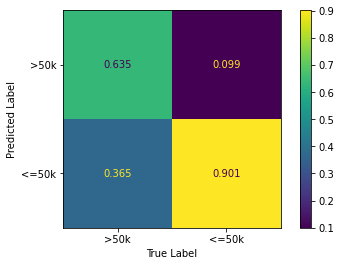

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0], normalize="pred" ),
                       display_labels=[">50k","<=50k"]).plot(values_format='.3f',ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
run.finish()